<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [412]:
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(10000)


class G:
    ITERATIONS = 100
    DURATIONS = 6120

G.target_times = {
    1: 2,
    2: 3,
    3: 5
}

G.specialties = {
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5'
}

def update_globals(urg_time, non_time):
    G.process_times = {
                        1: urg_time,
                        2: .3*(non_time - urg_time),
                        3: non_time
                    }
    
    

def create_arrival_times(sim_time, arr_rate):
    arrival_times = []
    time = 0
    while time < sim_time:
        time += np.random.exponential(arr_rate)
        arrival_times.append(time)
    return arrival_times

def create_medical_images(arrival_times):
    med_images = []
    for i, t in enumerate(arrival_times):
        med_images.append(MedicalImage(i, t, random.sample(list(G.target_times.keys()), 1)[0], random.sample(list(G.specialties.keys()), 1)[0]))
    return med_images

def create_radiologists(num_rads):
    radiologists = []
    for i in range(num_rads):
        specialties_temp = random.sample(list(G.specialties.keys()), random.randrange(2,len(G.specialties)))
        radiologists.append(Radiologist(i, specialties_temp))
    return radiologists


def create_initial_events(sim_duration, med_images):
    events=[]
    for img in med_images:
        events.append([img.time_created, 'New Job', img])
    events.append([sim_duration, "Sim End"])
    events = sorted(events, key=lambda x: x[0])
    return events


def start_simulation(events, med_images, radiologists):
    s = SystemState(events, med_images, radiologists)
    s.run_simulation()


class MedicalImage(object):    
    def __init__(self, img_id, time_created, urgency, image_type):#, modality, speciality, urgency, image_label):
        self.img_id = img_id
        self.time_created = time_created
        self.urgency = urgency
        self.image_type = image_type
        self.target_time = G.target_times[urgency]
        self.time_remaining = G.target_times[urgency]
        self.est_process_time = G.process_times[urgency]
        self.in_queues = []   #keep track on which queues image is in [rad_id, position]
        self.time_seen = 0
        self.time_done = 0
        self.rad_seen = "None"
        
    def update_time_remaining(self, t):
        self.time_remaining = self.target_time - (t - self.time_created)
        
        
class Radiologist:
    def __init__(self, rad_id, specialties, working=True):
        self.queue = []
        self.queue_data = []#[med_image, image_id, image_urgency, time_left, est_time]
        self.rad_id = rad_id
        self.specialties = specialties
        self.is_working = working
        self.is_idle = 1
        self.images_served = []
        self.idle_times = []
        self.time_busy_start = 0
        self.time_idle_start = 0
        self.busy_times = []
        self.time = 0
        self.time_of_step = 0
        self.queue_length = []
        self.service_starts = []
        self.service_ends = []
        self.service_time = []  
        
    def get_stats(self):
        return self.idle_times, self.busy_times, self.queue_length, self.service_starts, self.service_ends, self.service_time 
        
    def show_queue(self):
        return self.queue
    
    def add_job(self, med_image, time):
        if self.is_idle == 1:
            self.idle_times.append(time - self.time_idle_start)
            self.time_busy_start = time
        self.is_idle = 0
        self.queue.append(med_image)    #each customer is represented by the time it will take for them to be served
        self.queue_data.append([med_image, med_image.img_id, med_image.urgency, med_image.time_remaining, med_image.est_process_time, med_image.est_process_time]) #[image_id, image_urgency, time_left, est_time]
        # update time intervals
       
    def finish_job(self, time):
        if len(self.queue) == 0:
            self.time_finished_last_job = time
            self.time_idle_start = time
            self.busy_times.append(time - self.time_busy_start)
            self.is_idle = 1
    
    def update_idle_lists(self, time):
        if self.is_idle == 1:
            self.idle_times.append(time - self.time_idle_start)
        elif self.is_idle == 0:
            self.busy_times.append(time - self.time_busy_start)
        
    def update_queue(self, time):
        for img in self.queue:
            img.update_time_remaining(time)
        #sort_queue()        
    #def sort_queue(self):
                   
        
        
class SystemState:
    def __init__(self, sim_duration, events, images, rads, verbose=False):
        self.time = 0
        self.sim_duration = sim_duration
        self.continue_running = True
        self.events = events
        self.images = images
        self.rads = rads
        self.rads_working = rads
        self.rads_not_working = []
        self.events_history = []
        self.queue_lengths = []
        self.time_steps = []
        self.img_table = pd.DataFrame(columns=['img_id','urgency', 'create_time','seen_time', 'finished', 'img_wait_time', 'time_w_rad', 'total_time'])
        self.rad_table = pd.DataFrame()
        self.verbose = verbose
        
    def create_event(self, time, event_type, obj):
        self.events.append([time, event_type, obj])
        self.events = sorted(self.events, key=lambda x: x[0])

    def update_img_table(self, med_img):
        column_names = ['img_id','urgency', 'create_time','seen_time', 'finished','img_wait_time', 'time_w_rad', 'total_time']
        values = [med_img.img_id, med_img.urgency, med_img.time_created, med_img.time_seen, self.time, med_img.time_seen - med_img.time_created, self.time - med_img.time_seen, self.time - med_img.time_created] #[[med_img.time_created], [med_img.time_seen], [self.time], [self.time - med_img.time_seen], [self.time - med_img.time_created]]
        temp_df = pd.DataFrame(values).T
        temp_df.columns = column_names
        self.img_table = self.img_table.append(temp_df, ignore_index = True)
        
    def process_event(self):
        event = self.events[0]
        self.events_history.append(event)
        self.time = event[0]       
        event_type = event[1]
        del self.events[0]
        temp_list = []
        for r in self.rads:
            temp_list.append(len(r.queue))
        self.queue_lengths.append(temp_list)
        self.time_steps.append(self.time)
            
        if event_type == "New Job":
            self.distribute_job(event[2])
        elif event_type == "Job Done":
            rad = event[2]
            self.complete_job(rad)
        elif event_type == "Sim End":
            self.continue_running = False 
            for rad in self.rads:
                rad.update_idle_lists(self.time)
        if self.verbose==True:
            print("Event processed")
        if self.continue_running:
            self.process_event()
        else:
            print(f"Simulation complete at {self.time}")
                
    def distribute_job(self, med_image):
        image_type = med_image.image_type
        capable_rads = []
        for rad in self.rads_working:      #finds radiologists capable of working on image
            if image_type in rad.specialties:
                capable_rads.append(rad)
        for rad in capable_rads:
            rad.add_job(med_image, self.time)
            med_image.in_queues.append(rad)    #keep track of which rads have image in queue
            if len(rad.queue)==1:
                self.start_job(rad)
                break         
        self.update_queues()
             
    def update_queues(self):
        for rad in self.rads_working:
            rad.update_queue(self.time)
                
    def start_job(self, rad):
        med_image = rad.queue[0]
        image_type = med_image.image_type
        urgency = med_image.urgency
        rad.service_starts = self.time
        med_image.time_seen = self.time
        med_image.rad_seen = rad.rad_id
        self.events_history.append([self.time, "Job Started", med_image])
        process_time = np.random.exponential(G.target_times[urgency])
        self.create_event(self.time+process_time, "Job Done", rad)
        if self.verbose==True:
            print(f"Image {med_image.img_id} is seen by radiologist {rad.rad_id} at {self.time}")
        for r in med_image.in_queues:
            if r != rad:
                r.queue.remove(med_image)           
        
    def complete_job(self, rad):
        med_image = rad.queue[0]
        self.update_img_table(med_image)
        rad.images_served.append(med_image.img_id)
        rad.service_ends.append(self.time)
        med_image.time_done = self.time
        if self.verbose==True:
            print(f"Image {med_image.img_id} is done by radiologist {rad.rad_id} at {self.time}")
        del rad.queue[0]
        rad.finish_job(self.time)
        if len(rad.queue) > 0:
            self.start_job(rad)

    def run_simulation(self):
        self.process_event()

In [413]:
def gen_system_state(sim_time, rads_count, arr_rate, urg_time, non_time):
    #Define urgency times
    update_globals(urg_time, non_time)
    #Create the intervals
    arrival_times = create_arrival_times(sim_time, arr_rate)
    #Create the images with their arrival time_seen
    med_images = create_medical_images(arrival_times)
    #Create the radiologists
    radiologists = create_radiologists(rads_count)
    #Create the image arrival events
    events = create_initial_events(sim_time, med_images)
    s = SystemState(sim_time, events, med_images, radiologists)
    return s

def sim(sim_time, rads_count, arr_rate, urg_time, non_time):  
    s = gen_system_state(sim_time, rads_count, arr_rate, urg_time, non_time)
    s.run_simulation()    
    return s


def plot_queue_lengths(s):
    fig, ax = plt.subplots()
    for i in range(len(s.queue_lengths[0])):
        plt.plot(s.time_steps, [item[i] for item in s.queue_lengths])
        
def wait_time_plot(img_table):
    x=img_table['create_time'].values
    y=img_table['img_wait_time'].values
    plt.scatter(x, y)
    

def total_time_plot(img_table):
    x=img_table['create_time'].values
    y=img_table['total_time'].values
    plt.scatter(x, y)
    
        
def plt_mean_queue_length(s_list):
    fig, ax = plt.subplots()
    for s in s_list:
        plt.plot(s.time_steps, pd.DataFrame(s.queue_lengths).sum(axis=1), label=f"{len(s.rads)}")
    plt.xlabel("time")
    plt.ylabel("Mean Queue Length")
    plt.legend()
    plt.show()
    

def rad_idle_plot(rad):
    idle_times = rad.idle_times
    busy_times = rad.busy_times
    left_var = 0
    for i in range(len(idle_times)):
        plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
        left_var = left_var + idle_times[i]
        plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
        left_var = left_var + busy_times[i]

    plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.show()
    
def idle_plots(rads):
    plot_list = {}
    total_idle = 0
    total_busy = 0
    for rad in rads:
        idle_times = rad.idle_times
        busy_times = rad.busy_times
        left_var = 0
        for i in range(len(idle_times)):
            plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
            left_var = left_var + idle_times[i]
            plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
            left_var = left_var + busy_times[i]
        per_busy = np.sum(busy_times)/(np.sum(busy_times) + np.sum(idle_times))
        total_idle += np.sum(busy_times)
        total_busy += np.sum(idle_times)
        print(f"Radiologist {rad.rad_id} was busy {per_busy} of the time.")
        plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.xlabel("time")
    plt.ylabel("Radiologist ID")
    plt.show()
    total_per_busy = total_busy/(total_busy + total_idle)
    print(f"Radiologists were busy {total_per_busy} of the time.")

In [414]:
sim_time = 60 * 5
rads_count = 4
arr_rate = 1
urg_time = 10
non_time = 60

s1 = sim(sim_time, rads_count, arr_rate, urg_time, non_time)

Simulation complete at 300


In [415]:
s1.img_table

,img_id,urgency,create_time,seen_time,finished,img_wait_time,time_w_rad,total_time
0,1.0,1.0,2.803268,2.803268,5.437787,0.000000,2.634520,2.634520
1,2.0,3.0,3.030930,3.030930,9.432599,0.000000,6.401670,6.401670
2,0.0,3.0,1.305120,1.305120,9.492904,0.000000,8.187785,8.187785
3,3.0,1.0,3.610332,5.437787,10.912409,1.827455,5.474622,7.302077
4,4.0,1.0,5.292908,9.432599,11.327168,4.139691,1.894568,6.034260
...,...,...,...,...,...,...,...,...
272,270.0,2.0,288.977320,288.977320,292.720007,0.000000,3.742688,3.742688
273,273.0,3.0,293.743386,293.743386,294.326588,0.000000,0.583202,0.583202
274,274.0,1.0,294.047551,294.047551,295.518953,0.000000,1.471401,1.471401
275,275.0,3.0,294.679920,294.679920,297.762379,0.000000,3.082459,3.082459


In [416]:
[np.mean(s1.img_table[s1.img_table.urgency==1].total_time),
np.mean(s1.img_table[s1.img_table.urgency==2].total_time),
np.mean(s1.img_table[s1.img_table.urgency==3].total_time)]

[3.6468159796187467, 4.689961491119122, 6.596449561623616]

In [417]:
s1.time

300

(array([146.,  22.,  26.,  14.,  22.,  17.,  15.,   4.,   5.,   6.]),
 array([0.        , 0.80996255, 1.6199251 , 2.42988765, 3.2398502 ,
        4.04981276, 4.85977531, 5.66973786, 6.47970041, 7.28966296,
        8.09962551]),
 <BarContainer object of 10 artists>)

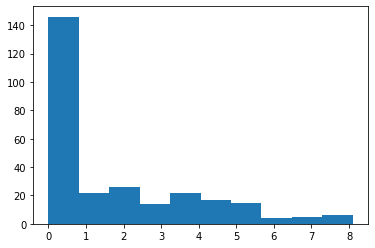

In [418]:
plt.hist(s1.img_table.img_wait_time)

(array([70., 68., 54., 41., 28.,  4.,  3.,  4.,  2.,  3.]),
 array([4.44964304e-03, 2.07748003e+00, 4.15051042e+00, 6.22354080e+00,
        8.29657119e+00, 1.03696016e+01, 1.24426320e+01, 1.45156624e+01,
        1.65886927e+01, 1.86617231e+01, 2.07347535e+01]),
 <BarContainer object of 10 artists>)

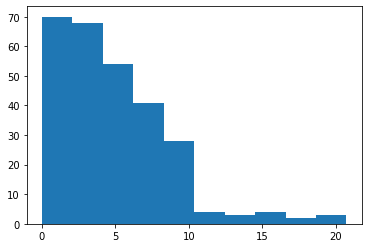

In [419]:
plt.hist(s1.img_table.total_time)

(array([15., 19., 15., 15., 10.,  8.,  7.,  6.,  6.,  4.]),
 array([0.01872119, 0.98047469, 1.9422282 , 2.9039817 , 3.86573521,
        4.82748871, 5.78924222, 6.75099572, 7.71274923, 8.67450273,
        9.63625624]),
 <BarContainer object of 10 artists>)

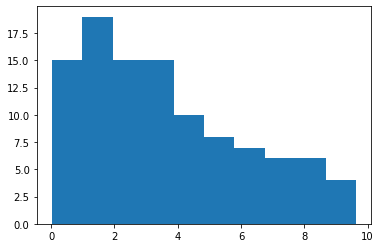

In [420]:
plt.hist(s1.img_table[s1.img_table.urgency==1].total_time)


(array([14., 12., 15., 11., 13., 11.,  4.,  3.,  1.,  2.]),
 array([ 0.09338062,  1.46686267,  2.84034471,  4.21382676,  5.58730881,
         6.96079086,  8.33427291,  9.70775495, 11.081237  , 12.45471905,
        13.8282011 ]),
 <BarContainer object of 10 artists>)

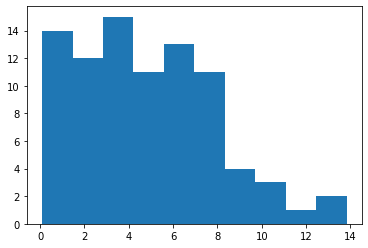

In [421]:
plt.hist(s1.img_table[s1.img_table.urgency==2].total_time)

(array([16., 16., 14., 14., 14.,  2.,  1.,  4.,  2.,  3.]),
 array([4.44964304e-03, 2.07748003e+00, 4.15051042e+00, 6.22354080e+00,
        8.29657119e+00, 1.03696016e+01, 1.24426320e+01, 1.45156624e+01,
        1.65886927e+01, 1.86617231e+01, 2.07347535e+01]),
 <BarContainer object of 10 artists>)

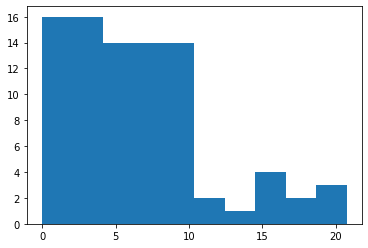

In [422]:
plt.hist(s1.img_table[s1.img_table.urgency==3].total_time)

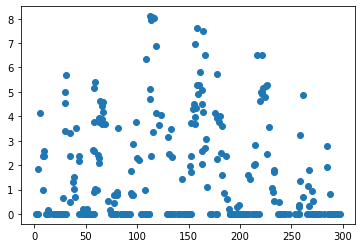

In [423]:
wait_time_plot(s1.img_table)

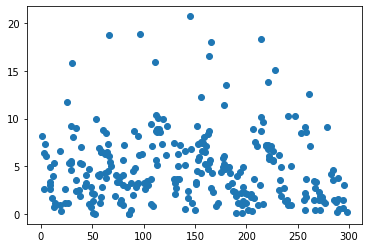

In [424]:
total_time_plot(s1.img_table)

In [425]:
def rad_idle_plot(rad):
    idle_times = rad.idle_times
    busy_times = rad.busy_times
    left_var = 0
    for i in range(len(idle_times)):
        plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
        left_var = left_var + idle_times[i]
        if i < len(busy_times):
                plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
                left_var = left_var + busy_times[i]

    plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.show()
    
def idle_plots(rads):
    plot_list = {}
    total_idle = 0
    total_busy = 0
    for rad in rads:
        idle_times = rad.idle_times
        busy_times = rad.busy_times
        left_var = 0
        for i in range(len(idle_times)):
            plt.barh(rad.rad_id, idle_times[i], left=left_var, color="red")
            left_var = left_var + idle_times[i]
            if i < len(busy_times):
                plt.barh(rad.rad_id, busy_times[i], left=left_var, color="orange")
                left_var = left_var + busy_times[i]
        per_busy = np.sum(busy_times)/(np.sum(busy_times) + np.sum(idle_times))
        total_idle += np.sum(idle_times)
        total_busy += np.sum(busy_times)
        print(f"Radiologist {rad.rad_id} was busy {per_busy} of the time.")
        plt.legend(["idle", "busy"], title="Idle Times", loc="upper right")
    plt.xlabel("time")
    plt.ylabel("Radiologist ID")
    plt.show()
    total_per_busy = total_busy/(total_busy + total_idle)
    print(f"Radiologists were busy {total_per_busy} of the time.")
    return total_per_busy

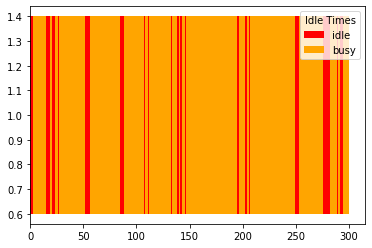

In [426]:
rad_idle_plot(s1.rads[1])

In [427]:
sim_time = 60*5
rads_count = 6
arr_rate = 1
urg_time = 10
non_time = 60

s1 = sim(sim_time, rads_count, arr_rate, urg_time, non_time)

Simulation complete at 300


Radiologist 0 was busy 0.782530949045056 of the time.
Radiologist 1 was busy 0.7085634586837892 of the time.
Radiologist 2 was busy 0.4466293270933278 of the time.
Radiologist 3 was busy 0.5258491403231513 of the time.
Radiologist 4 was busy 0.2483358485429414 of the time.
Radiologist 5 was busy 0.45860284456382316 of the time.


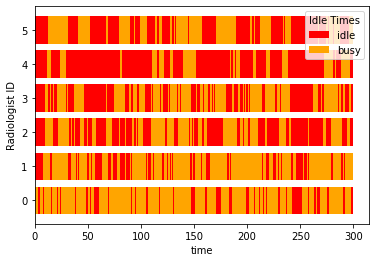

Radiologists were busy 0.5284185947086815 of the time.


0.5284185947086815

In [428]:
idle_plots(s1.rads)

Simulation complete at 300
Radiologist 0 was busy 0.9998662223846202 of the time.
Radiologist 1 was busy 0.9989470506640746 of the time.
Radiologist 2 was busy 0.9980362256051829 of the time.
Radiologist 3 was busy 0.9997009163873575 of the time.
Radiologist 4 was busy 0.9993446618907219 of the time.
Radiologist 5 was busy 0.9937994210451602 of the time.


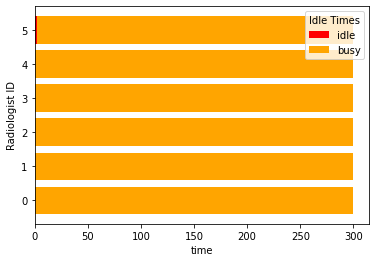

Radiologists were busy 0.9982824163295194 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.9992764708757002 of the time.
Radiologist 1 was busy 0.9978941879603739 of the time.
Radiologist 2 was busy 0.996312322734064 of the time.
Radiologist 3 was busy 0.9929594536549947 of the time.
Radiologist 4 was busy 0.9934792915419278 of the time.
Radiologist 5 was busy 0.9922174308487831 of the time.


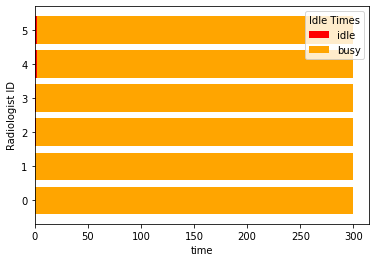

Radiologists were busy 0.9953565262693073 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.9972816891511239 of the time.
Radiologist 1 was busy 0.9970550438656479 of the time.
Radiologist 2 was busy 0.9901101574998542 of the time.
Radiologist 3 was busy 0.9944084901734727 of the time.
Radiologist 4 was busy 0.988127344597429 of the time.
Radiologist 5 was busy 0.9836175605587382 of the time.


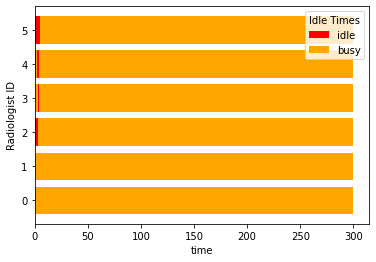

Radiologists were busy 0.991766714307711 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.994155110514619 of the time.
Radiologist 1 was busy 0.9967998744888367 of the time.
Radiologist 2 was busy 0.9945417795510855 of the time.
Radiologist 3 was busy 0.9910801104864324 of the time.
Radiologist 4 was busy 0.9929224622333417 of the time.
Radiologist 5 was busy 0.9911301024561529 of the time.


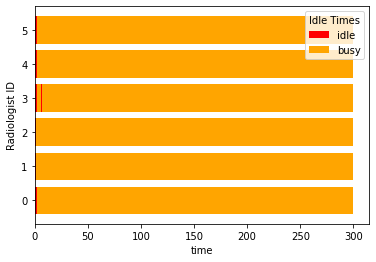

Radiologists were busy 0.9934382399550781 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.9890241339379016 of the time.
Radiologist 1 was busy 0.9780059451070477 of the time.
Radiologist 2 was busy 0.9994462667751096 of the time.
Radiologist 3 was busy 0.991882568627305 of the time.
Radiologist 4 was busy 0.9927699579686606 of the time.
Radiologist 5 was busy 0.9905024779570106 of the time.


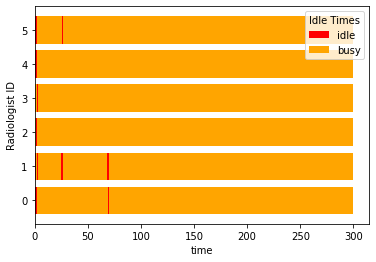

Radiologists were busy 0.9902718917288392 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.8438996633779698 of the time.
Radiologist 1 was busy 0.8952533662768021 of the time.
Radiologist 2 was busy 0.8050378222750351 of the time.
Radiologist 3 was busy 0.6244049774916417 of the time.
Radiologist 4 was busy 0.6585760196954783 of the time.
Radiologist 5 was busy 0.5255088491674995 of the time.


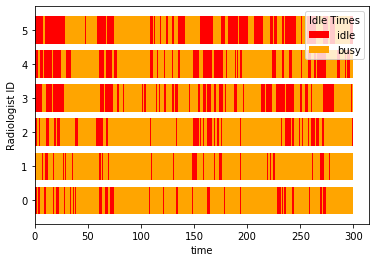

Radiologists were busy 0.7254467830474045 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.9392047515153371 of the time.
Radiologist 1 was busy 0.8037910920931983 of the time.
Radiologist 2 was busy 0.8968400598722703 of the time.
Radiologist 3 was busy 0.7599276983182993 of the time.
Radiologist 4 was busy 0.788363644817452 of the time.
Radiologist 5 was busy 0.779141415578733 of the time.


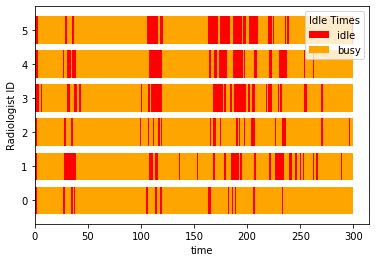

Radiologists were busy 0.8278781103658817 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.745807202638847 of the time.
Radiologist 1 was busy 0.7043321140522684 of the time.
Radiologist 2 was busy 0.7053630225866455 of the time.
Radiologist 3 was busy 0.6275826862508046 of the time.
Radiologist 4 was busy 0.34778183431503085 of the time.
Radiologist 5 was busy 0.4145158355109068 of the time.


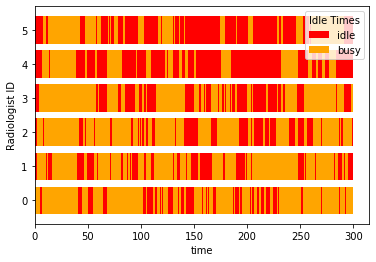

Radiologists were busy 0.5908971158924172 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.657525064431652 of the time.
Radiologist 1 was busy 0.8568266328797626 of the time.
Radiologist 2 was busy 0.6631006894421525 of the time.
Radiologist 3 was busy 0.7547796291508081 of the time.
Radiologist 4 was busy 0.5349317019320198 of the time.
Radiologist 5 was busy 0.5373596738548317 of the time.


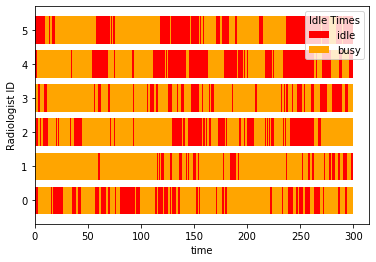

Radiologists were busy 0.6674205652818711 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.734064419532999 of the time.
Radiologist 1 was busy 0.6123133474974878 of the time.
Radiologist 2 was busy 0.5464350818880924 of the time.
Radiologist 3 was busy 0.4987247160571378 of the time.
Radiologist 4 was busy 0.32745914170964 of the time.
Radiologist 5 was busy 0.21790320615554842 of the time.


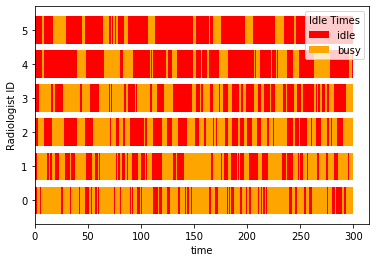

Radiologists were busy 0.4894833188068176 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.6682199066630431 of the time.
Radiologist 1 was busy 0.7282220270873743 of the time.
Radiologist 2 was busy 0.3925758998724972 of the time.
Radiologist 3 was busy 0.39382624691001855 of the time.
Radiologist 4 was busy 0.3499771940460619 of the time.
Radiologist 5 was busy 0.07980467313098244 of the time.


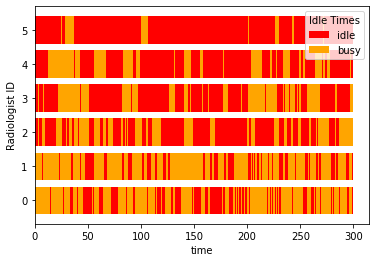

Radiologists were busy 0.4354376579516629 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.6364654523404987 of the time.
Radiologist 1 was busy 0.5691309786285266 of the time.
Radiologist 2 was busy 0.48226314981090024 of the time.
Radiologist 3 was busy 0.33071959284533636 of the time.
Radiologist 4 was busy 0.30361167237037745 of the time.
Radiologist 5 was busy 0.19596018728880582 of the time.


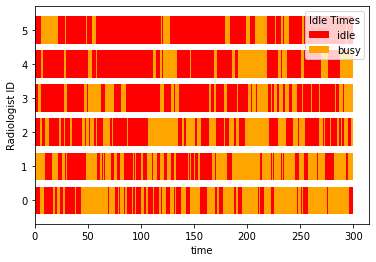

Radiologists were busy 0.4196918388807408 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.6418252083276247 of the time.
Radiologist 1 was busy 0.7626079331004564 of the time.
Radiologist 2 was busy 0.5109877056034798 of the time.
Radiologist 3 was busy 0.43252791638884047 of the time.
Radiologist 4 was busy 0.38748718264487186 of the time.
Radiologist 5 was busy 0.08488657973653893 of the time.


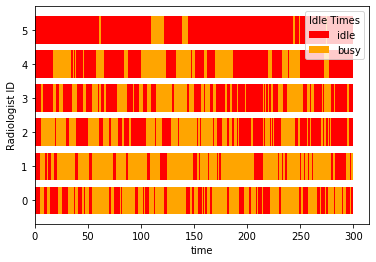

Radiologists were busy 0.470053754300302 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.4809875150930033 of the time.
Radiologist 1 was busy 0.5631875409825524 of the time.
Radiologist 2 was busy 0.31938739698462515 of the time.
Radiologist 3 was busy 0.3423873328823082 of the time.
Radiologist 4 was busy 0.3092162790994915 of the time.
Radiologist 5 was busy 0.12093813316471516 of the time.


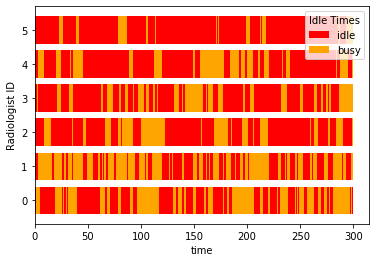

Radiologists were busy 0.3560173663677827 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.4345039305439468 of the time.
Radiologist 1 was busy 0.5655454671843212 of the time.
Radiologist 2 was busy 0.42670976073167016 of the time.
Radiologist 3 was busy 0.48871531656365796 of the time.
Radiologist 4 was busy 0.06410276961262952 of the time.
Radiologist 5 was busy 0.15538009028050553 of the time.


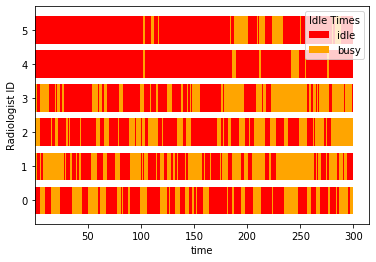

Radiologists were busy 0.35582622248612183 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.5880792919164756 of the time.
Radiologist 1 was busy 0.508776376622286 of the time.
Radiologist 2 was busy 0.3407929993884699 of the time.
Radiologist 3 was busy 0.05364243818853813 of the time.
Radiologist 4 was busy 0.0464274111586247 of the time.
Radiologist 5 was busy 0.19571425098840783 of the time.


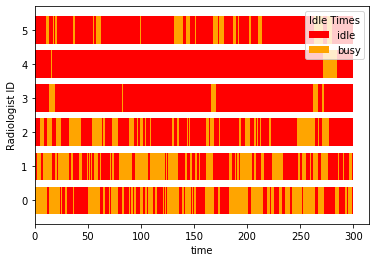

Radiologists were busy 0.28890546137713374 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.6102302116519728 of the time.
Radiologist 1 was busy 0.5837612675918825 of the time.
Radiologist 2 was busy 0.32937730860171305 of the time.
Radiologist 3 was busy 0.27353285282182044 of the time.
Radiologist 4 was busy 0.12287212272239142 of the time.
Radiologist 5 was busy 0.20787592386426065 of the time.


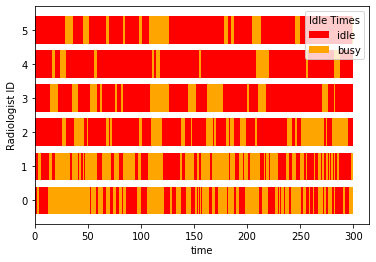

Radiologists were busy 0.35460828120900684 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.412004155106918 of the time.
Radiologist 1 was busy 0.5397668669739587 of the time.
Radiologist 2 was busy 0.409690720126834 of the time.
Radiologist 3 was busy 0.19872719157379212 of the time.
Radiologist 4 was busy 0.06446199263308901 of the time.
Radiologist 5 was busy 0.1115393664968901 of the time.


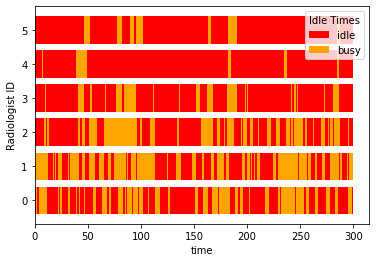

Radiologists were busy 0.28936504881858033 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.6245243655762401 of the time.
Radiologist 1 was busy 0.3917139803484997 of the time.
Radiologist 2 was busy 0.24263003857199947 of the time.
Radiologist 3 was busy 0.2468854173793253 of the time.
Radiologist 4 was busy 0.09555698808922101 of the time.
Radiologist 5 was busy 0.1308923369168226 of the time.


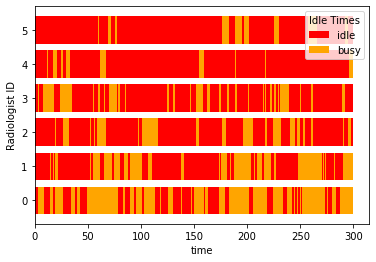

Radiologists were busy 0.2887005211470181 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.5916289628117473 of the time.
Radiologist 1 was busy 0.3576563569718249 of the time.
Radiologist 2 was busy 0.294046557742939 of the time.
Radiologist 3 was busy 0.18906777120591953 of the time.
Radiologist 4 was busy 0.05462552388598221 of the time.
Radiologist 5 was busy 0.06543666822719511 of the time.


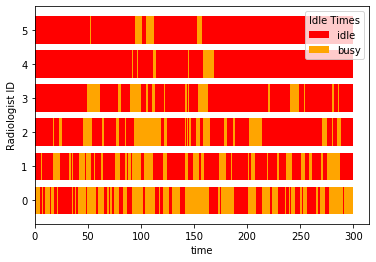

Radiologists were busy 0.2587436401409347 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.5850484750794571 of the time.
Radiologist 1 was busy 0.5182611674036369 of the time.
Radiologist 2 was busy 0.11695262543988334 of the time.
Radiologist 3 was busy 0.21709997129892494 of the time.
Radiologist 4 was busy 0.15502761818489633 of the time.
Radiologist 5 was busy 0.05034419429606333 of the time.


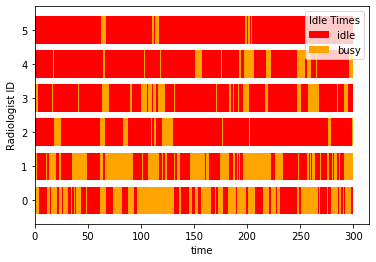

Radiologists were busy 0.27378900861714367 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.5059310398439943 of the time.
Radiologist 1 was busy 0.5477644860922269 of the time.
Radiologist 2 was busy 0.1535499205545721 of the time.
Radiologist 3 was busy 0.24660503784380475 of the time.
Radiologist 4 was busy 0.06020164651745765 of the time.
Radiologist 5 was busy 0.008743617383476992 of the time.


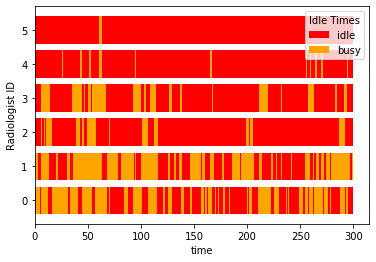

Radiologists were busy 0.2537992913725888 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.34279849794813133 of the time.
Radiologist 1 was busy 0.41605594887258734 of the time.
Radiologist 2 was busy 0.31191409426934286 of the time.
Radiologist 3 was busy 0.013964005034576323 of the time.
Radiologist 4 was busy 0.07847951869041035 of the time.
Radiologist 5 was busy 0.005593681602616011 of the time.


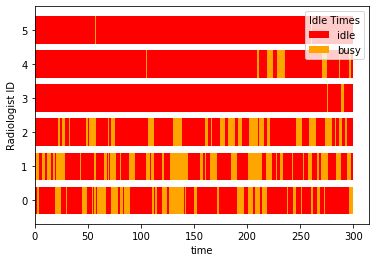

Radiologists were busy 0.1948009577362773 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.5386159249483942 of the time.
Radiologist 1 was busy 0.3285790772303615 of the time.
Radiologist 2 was busy 0.3062049098576555 of the time.
Radiologist 3 was busy 0.11136250831290621 of the time.
Radiologist 4 was busy 0.14118435591423725 of the time.
Radiologist 5 was busy 0.022585119043628955 of the time.


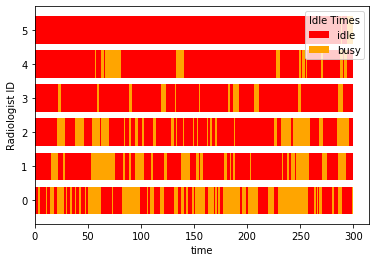

Radiologists were busy 0.24142198255119726 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.46372490352347834 of the time.
Radiologist 1 was busy 0.3121278026536712 of the time.
Radiologist 2 was busy 0.09949041896402706 of the time.
Radiologist 3 was busy 0.05939116636801553 of the time.
Radiologist 4 was busy 0.07142880652778094 of the time.
Radiologist 5 was busy 0.04384979543376981 of the time.


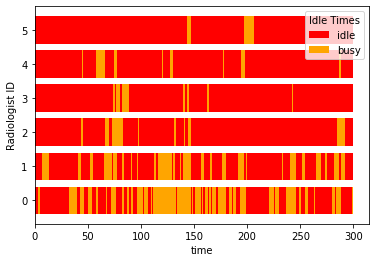

Radiologists were busy 0.17500214891179044 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.3752044175164869 of the time.
Radiologist 1 was busy 0.38499253960426805 of the time.
Radiologist 2 was busy 0.14908788740166098 of the time.
Radiologist 3 was busy 0.2112230867238401 of the time.
Radiologist 4 was busy 0.037582105600309224 of the time.
Radiologist 5 was busy 0.03591364678904313 of the time.


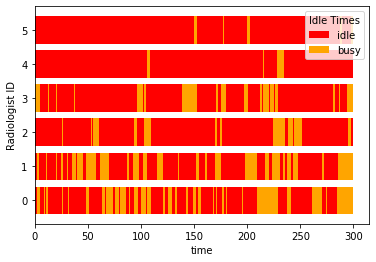

Radiologists were busy 0.19900061393926805 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.3188457007273345 of the time.
Radiologist 1 was busy 0.13530323791018642 of the time.
Radiologist 2 was busy 0.2670186237922616 of the time.
Radiologist 3 was busy 0.0460402921459008 of the time.
Radiologist 4 was busy 0.33129704794699494 of the time.
Radiologist 5 was busy 0.028134522282950627 of the time.


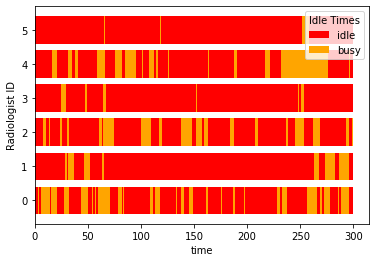

Radiologists were busy 0.1877732374676048 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.4512933274849433 of the time.
Radiologist 1 was busy 0.37997397331143196 of the time.
Radiologist 2 was busy 0.23462175094884402 of the time.
Radiologist 3 was busy 0.15903604194155127 of the time.
Radiologist 4 was busy 0.12804907358409254 of the time.
Radiologist 5 was busy 0.023232859937025837 of the time.


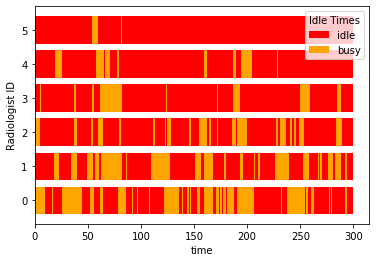

Radiologists were busy 0.22936783786798146 of the time.
Simulation complete at 300
Radiologist 0 was busy 0.3132893253538065 of the time.
Radiologist 1 was busy 0.32999263851932703 of the time.
Radiologist 2 was busy 0.2222247083807825 of the time.
Radiologist 3 was busy 0.12941304279109497 of the time.
Radiologist 4 was busy 0.05440546132401168 of the time.
Radiologist 5 was busy 0.0 of the time.


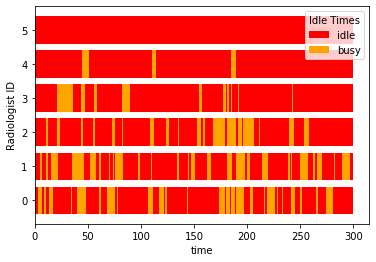

Radiologists were busy 0.1748875293948371 of the time.


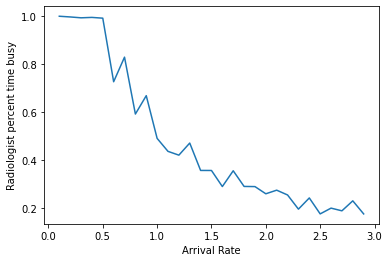

In [429]:
busy_times = {}
for arr_rate_var in np.arange(0.1, 3.0, 0.1):
    sim_time = 60*5
    rads_count = 6
    arr_rate = arr_rate_var
    urg_time = 10
    non_time = 60

    s1 = sim(sim_time, rads_count, arr_rate, urg_time, non_time)
    busy_times[arr_rate] = idle_plots(s1.rads)
plt.plot(busy_times.keys(), busy_times.values())
plt.xlabel("Arrival Rate")
plt.ylabel("Radiologist percent time busy")
plt.show()

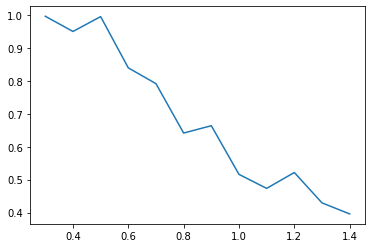

In [170]:
rad_1.idle_times, rad_1.busy_times

([0.28358740466897614,
  0.023542100711864578,
  0.3183700815247148,
  0.36760775931460454,
  0.5186982995792739,
  15.54413793712255,
  1.0807202884304559,
  4.323352390037222,
  0.3603734934664118,
  1.8747216583866901],
 [2.455916597837967,
  1.1788136916891752,
  3.323503010742252,
  3.4891798378168266,
  4.973310951297391,
  3.806926691002772,
  5.555062341561445,
  1.8393776695090693,
  1.2106831592634535,
  5.255643235579356])

In [ ]:
@app.callback(Output('call-wait-time-graph', 'figure'),
              [Input('agent_table', 'children'),
               Input('live-update-graph', 'hoverData')])
def wait_time_graph(rad_table, time_filter):
    '''
    '''
    agent_table_df = pd.read_json(agent_table_json, orient='split')
    #print('agent_table: ', agent_table_df_orig)
    
    current_hover = None
    if time_filter is not None:
        if time_filter['points'][0]['customdata'] != 'showall':
            current_hover = dt.datetime.strptime(time_filter['points'][0]['customdata'], "%Y-%m-%d %H:%M:%S")
    
    if current_hover is not None:
            agent_table_df = agent_table_df[agent_table_df['intvl_time_elapsed'] == cgd.timeElapsed(current_hover)].reset_index()

    traces=[]
    colorlist = []
    
    for x in agent_table_df['call_wait_time_elapsed'].tolist():
        if x > 60:
            colorlist.append('rgb(244,109,67)') #Red
        else:
            colorlist.append('rgb(128,205,193)') #Green
            
    traces.append(go.Scatter(
            x=agent_table_df['call_handle_start_time'],
            y=agent_table_df['call_wait_time_elapsed'],
            mode='markers', 
            marker={'color': colorlist, 'opacity': 0.8, 'line': {'width': 0.5, 'color': 'white'}},
            name=''))
    
    return {
        'data': traces,
        'layout': go.Layout(
            height=225,
            margin=margin,
            title="Avg. Call Wait Time: {:.2f} sec".format(round(sum(agent_table_df['call_wait_time_elapsed'])/float(len(agent_table_df))),2),
            xaxis={'zeroline': False},
            yaxis={'title': '', 'range':[0, max(agent_table_df['call_wait_time_elapsed'])*1.1], 'zeroline': False},
            hovermode='closest',
            font=dict(family='Raleway')
        )
    }